In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf 
import os

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

In [46]:
# data
ticker = 'ANF'
start_date = '2010-01-02'
end_date = '2019-12-31'
n_lags = 3

valid_size = 12
batch_size = 5
n_epochs = 1000

In [47]:
df = yf.download(ticker,
    start = start_date,
    end = end_date,
    progress = False)

df = df.resample('M').last()
prices = df['Adj Close'].values

Text(0, 0.5, 'Price ($)')

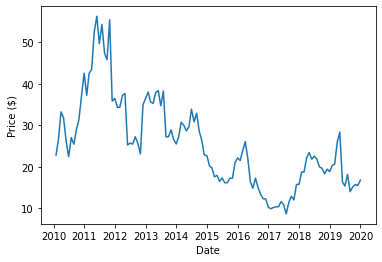

In [48]:
fig, ax = plt.subplots( )

ax.plot(df.index, prices)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

In [49]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    '''
    Function for transforming time series into input acceptable by multilayer perceptron.abs

    Parameters
    ----------
    series : np.array
        Array of features 
    n_steps_in : int
        The number of lagged observations to consider as features

    Returns 
    -------
    X : np.array 
        Array of features 
    Y : np.array 
        Array of features
    '''

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        X.append(sequence[i:end_ix])
        y.append(sequence[end_ix:out_end_ix])
    return np.array(X), np.array(y)

In [50]:
X, y = split_sequence(prices, 3,1)

In [51]:
valid_ind =  valid_size

X_train = X[:-valid_ind]
y_train = y[:-valid_ind].reshape(-1,1)

X_val = X[-valid_ind:]
y_val = y[-valid_ind:].reshape(-1,1)

In [52]:
print(X_train[1])
print(y_train[0])

[26.52302933 33.23754501 31.84658432]
[31.84658432]


In [53]:
print(f'Size of datasets - training: {X_train.shape[0]} | validation: {X_val.shape[0]}')

Size of datasets - training: 105 | validation: 12


In [62]:
# One step behind!
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]
mse = tf.keras.losses.MeanSquaredError()
naive_mse = mse(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print(f"Naive forecast - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

Naive forecast - MSE: 17.37, RMSE: 4.17


In [63]:
class MLP(tf.keras.Model):

    # In __init__, we define the Model's layers
    def __init__(self,steps_out, batch_size):
        super(MLP, self).__init__()
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu', input_shape=(3,))
        self.drop_out_layer_1 = tf.keras.layers.Dropout(0.2)
        self.dense_layer2 = tf.keras.layers.Dense(4, activation = 'relu' )
        self.drop_out_layer_2 = tf.keras.layers.Dropout(0.2)
        self.dense_layer3 = tf.keras.layers.Dense(steps_out, activation = 'relu' )

    # In the call function, we define the Model's forward pass.
    def build(self):
        model = tf.keras.Sequential([
        # Layer 1: 
        self.dense_layer1,
        self.drop_out_layer_1,
        # Layer 2:
        self.dense_layer2,
        self.drop_out_layer_2,
        # Layer 3:
        self.dense_layer3 
        ])

        return model

In [64]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 3 # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 0.0001  # Experiment between 1e-5 and 1e-1

# Model parameters: 
steps_in = 3
steps_out = 1
# rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [65]:
tf.random.set_seed(42)

model = MLP(steps_out, batch_size).build()
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 8)                 32        
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [69]:

@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:

        y_hat = model(x) # TODO

        loss = mse(y, y_hat) # TODO

        # Now, compute the gradients 
        grads = tape.gradient(loss, model.trainable_variables) # TODO

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

##################
# Begin training!#
##################

history = []

for epoch in tqdm(range(len(X_train))):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = X_train[epoch].reshape(1,batch_size), y_train[epoch].reshape(1,1)
    loss = train_step(x_batch, y_batch)

    # Update the progress bar
    history.append(loss.numpy().mean())

    # Update the model with the changed weights!
    if epoch % 100 == 0:     
        model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)


100%|██████████| 105/105 [00:00<00:00, 391.62it/s]


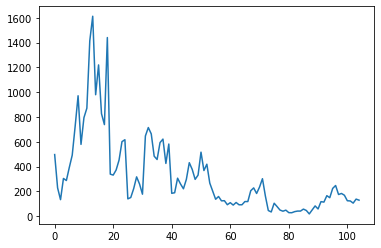

In [71]:
fig, ax = plt.subplots()
ax.plot(history)

In [67]:
PRINT_EVERY = 50
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    running_loss_train = 0
    running_loss_valid = 0

    model.train()
    
    for x_batch, y_batch in train_loader:
        
        optimizer.zero_grad()
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_hat = model(x_batch)
        loss = loss_fn(y_batch, y_hat)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * x_batch.size(0)
        
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_losses.append(epoch_loss_train)

    with torch.no_grad():
        
        model.eval()
        
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_hat = model(x_val)
            loss = loss_fn(y_val, y_hat)
            running_loss_valid += loss.item() * x_val.size(0)
            
        epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
            
        if epoch > 0 and epoch_loss_valid < min(valid_losses):
            best_epoch = epoch
            torch.save(model.state_dict(), './mlp_checkpoint.pth')
            
        valid_losses.append(epoch_loss_valid)

    if epoch % PRINT_EVERY == 0:
        print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
        
print(f'Lowest loss recorded in epoch: {best_epoch}')

AttributeError: 'Sequential' object has no attribute 'train'

In [99]:
tf.random.set_seed(42)
model = MLP(3,1)